# Problem and Data Description

There is a ton of real-time data on Twitter. Some of it pertains to natural disaster events. Agenices programatically monitor Twitter to find this information. Machine learning can be used to scrape individual Tweets from Twitter and obtain information or sentiment from these Tweets. This project will use a dataset of Tweets and build models to predict if a particular Tweet is about a real disaster.

The dataset contains data about 10,000 tweets: the text, the location, and a keyword of the tweet. The data is split into training and testing sets. The train dataset contains a target column that tells us if the tweet is about a disaster (marked as 1) or not (marked as 0) to help us build our models.

# Exploratory Data Analysis

In [1]:
# Load needed libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.metrics import accuracy_score

In [28]:
# Load Data

train = pd.read_csv("../input/nlp-getting-started/train.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

Data exploration:

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The outputs from the two lines of code above show us an initial look at the training data. There are a total of 7,613 tweets in this data, as identified by the 'id'. The data contains the 'text' of the tweet as well as the 'target' that tells us if the tweet is about a disaster or not. The 'keyword' and 'location' of the tweets both contain missing values. These missing values would need to be addressed before proceeding, however this analysis will only be using the 'text' and 'target' data to build our models.

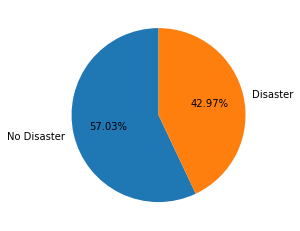

In [5]:
plt.pie(train['target'].value_counts(), labels = ['No Disaster','Disaster'], 
        autopct = '%1.2f%%', startangle = 90)
plt.show()

When it comes to binary classification, an even 50/50 split in the training data between the two classes is ideal. Our training data is a 57/43 split with the 57% labeled as not a disaster. This is close enough for us to believe this slight imbalance won't have an effect on our model building.

In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


# Data Preprocessing

We'll need to do some data preprocessing to get it ready for model training. The first thing we'll do is remove stop words from the text. Stop words are basic, common words that are considered as uninformative.

In [8]:
stop_words = stopwords.words('english')
train['clean_text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

Now we will use tokenization to convert the text into a sequence of integers where each integer represents the index of a word in a dictionary. The sequences will be padded to a max length of 100.

In [9]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(train['clean_text'])
train_seq = tokenizer.texts_to_sequences(train['clean_text'])
train_pad = pad_sequences(train_seq, maxlen = 100)

20% of the training data will get randomly split into a testing set and the remaining 80% will be used to train our models.

In [10]:
# Split data

x_train, x_test, y_train, y_test = train_test_split(train_pad, train['target'], test_size=0.2, random_state=42)

Our training data will be reshaped to 3D for model training.

In [11]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Model Architecture

Our first model will be a simple LSTM (Long Short Term Memory) model. There are a total of 4 LSTM layers. The output layer uses sigmoid activation. We'll train our model over 25 iterations.

In [12]:
# LSTM Model

lstm_model = Sequential()

# Fist Layer
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))

# Second Layer
lstm_model.add(LSTM(units=50, return_sequences=True))

# Third Layer
lstm_model.add(LSTM(units=50, return_sequences=True))

# Fourth Layer
lstm_model.add(LSTM(units=50))

# Output Layer
lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC()])

2022-11-13 23:57:44.287116: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
# LSTM Model Summary

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [14]:
# LSTM Model Training

lstm_model_training = lstm_model.fit(x_train, y_train, epochs=25, validation_data=(x_test,y_test))

2022-11-13 23:58:00.724822: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
191/191 [==============================] - 79s 366ms/step - loss: 0.6539 - accuracy: 0.6087 - auc: 0.6407 - val_loss: 0.6446 - val_accuracy: 0.6520 - val_auc: 0.6822
Epoch 2/25
191/191 [==============================] - 69s 363ms/step - loss: 0.6397 - accuracy: 0.6419 - auc: 0.6715 - val_loss: 0.6330 - val_accuracy: 0.6454 - val_auc: 0.6939
Epoch 3/25
191/191 [==============================] - 67s 352ms/step - loss: 0.6361 - accuracy: 0.6415 - auc: 0.6776 - val_loss: 0.6341 - val_accuracy: 0.6382 - val_auc: 0.6818
Epoch 4/25
191/191 [==============================] - 67s 353ms/step - loss: 0.6339 - accuracy: 0.6465 - auc: 0.6807 - val_loss: 0.6259 - val_accuracy: 0.6632 - val_auc: 0.6955
Epoch 5/25
191/191 [==============================] - 67s 353ms/step - loss: 0.6329 - accuracy: 0.6443 - auc: 0.6829 - val_loss: 0.6313 - val_accuracy: 0.6573 - val_auc: 0.7000
Epoch 6/25
191/191 [==============================] - 67s 350ms/step - loss: 0.6301 - accuracy: 0.6506 - auc: 0.687

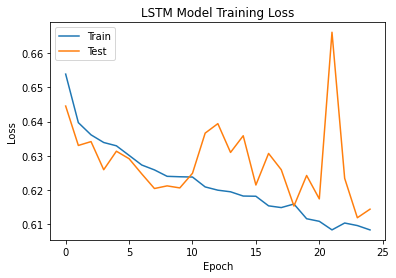

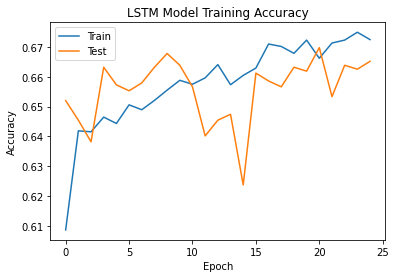

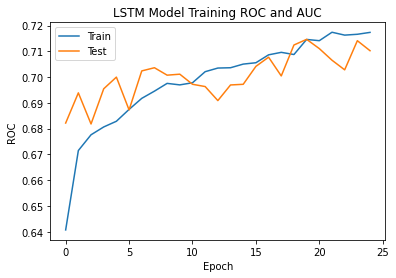

In [15]:
# LSTM Model Plots

plt.plot(lstm_model_training.history['loss'])
plt.plot(lstm_model_training.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Model Training Loss')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

plt.plot(lstm_model_training.history['accuracy'])
plt.plot(lstm_model_training.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Model Training Accuracy')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

plt.plot(lstm_model_training.history['auc'])
plt.plot(lstm_model_training.history['val_auc'])
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.title('LSTM Model Training ROC and AUC')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

Our second model will be a GRU (Gated Recurrent Unit) model. This model will have the same structure as our LSTM model so that we can easily compare the two. GRU is more simple than LSTM so we'll see how this performs compared to our LSTM model.

In [16]:
# GRU Model

gru_model = Sequential()

# Fist Layer
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))

# Second Layer
gru_model.add(GRU(units=50, return_sequences=True))

# Third Layer
gru_model.add(GRU(units=50, return_sequences=True))

# Fourth Layer
gru_model.add(GRU(units=50))

# Output Layer
gru_model.add(Dense(units=1, activation='sigmoid'))

gru_model.compile(loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC()])

In [17]:
# GRU Model Summary

gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 50)           7950      
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 50)           15300     
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 50)           15300     
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                15300     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 53,901
Trainable params: 53,901
Non-trainable params: 0
_________________________________________________________________


In [18]:
# GRU Model Training

gru_model_training = gru_model.fit(x_train, y_train, epochs=25, validation_data=(x_test,y_test))

Epoch 1/25
191/191 [==============================] - 93s 436ms/step - loss: 0.6474 - accuracy: 0.6335 - auc_1: 0.6569 - val_loss: 0.6343 - val_accuracy: 0.6395 - val_auc_1: 0.6851
Epoch 2/25
191/191 [==============================] - 81s 426ms/step - loss: 0.6390 - accuracy: 0.6376 - auc_1: 0.6727 - val_loss: 0.6261 - val_accuracy: 0.6474 - val_auc_1: 0.6941
Epoch 3/25
191/191 [==============================] - 83s 437ms/step - loss: 0.6361 - accuracy: 0.6430 - auc_1: 0.6769 - val_loss: 0.6312 - val_accuracy: 0.6553 - val_auc_1: 0.6928
Epoch 4/25
191/191 [==============================] - 82s 431ms/step - loss: 0.6332 - accuracy: 0.6499 - auc_1: 0.6818 - val_loss: 0.6227 - val_accuracy: 0.6546 - val_auc_1: 0.6990
Epoch 5/25
191/191 [==============================] - 81s 426ms/step - loss: 0.6306 - accuracy: 0.6493 - auc_1: 0.6866 - val_loss: 0.6388 - val_accuracy: 0.6408 - val_auc_1: 0.6823
Epoch 6/25
191/191 [==============================] - 81s 424ms/step - loss: 0.6299 - accuracy:

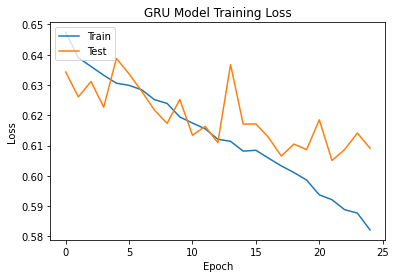

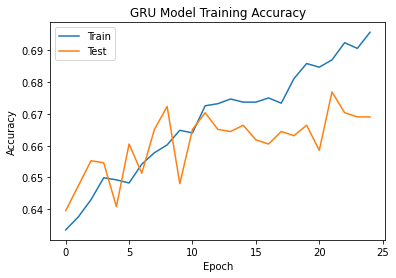

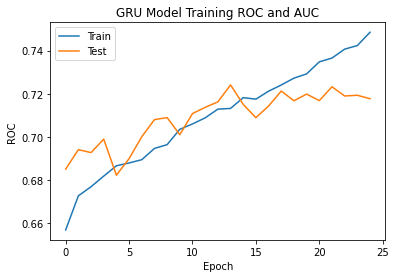

In [20]:
# GRU Model Plots

plt.plot(gru_model_training.history['loss'])
plt.plot(gru_model_training.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU Model Training Loss')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

plt.plot(gru_model_training.history['accuracy'])
plt.plot(gru_model_training.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GRU Model Training Accuracy')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

plt.plot(gru_model_training.history['auc_1'])
plt.plot(gru_model_training.history['val_auc_1'])
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.title('GRU Model Training ROC and AUC')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

Comparing the LSTM and GRU models, the metrics Loss, Accuracy, and ROC/AUC were slightly better for the GRU model judging by the plots. So for our third model, we will build a little more advanced GRU model. We will add tanh activation at each GRU layer as well as a dropout rate of 0.1.

In [21]:
# Advanced GRU Model

adv_gru_model = Sequential()

# Fist Layer
adv_gru_model.add(GRU(units=50, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1],1)))
adv_gru_model.add(Dropout(0.1))

# Second Layer
adv_gru_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
adv_gru_model.add(Dropout(0.1))

# Third Layer
adv_gru_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
adv_gru_model.add(Dropout(0.1))

# Fourth Layer
adv_gru_model.add(GRU(units=50, activation='tanh'))
adv_gru_model.add(Dropout(0.1))

# Output Layer
adv_gru_model.add(Dense(units=1, activation='sigmoid'))

adv_gru_model.compile(loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC()])

In [22]:
# Advanced GRU Model Summary

adv_gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 100, 50)           7950      
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 100, 50)           15300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
gru_6 (GRU)                  (None, 100, 50)           15300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 50)               

In [23]:
# Advanced GRU Model Training

adv_gru_model_training = adv_gru_model.fit(x_train, y_train, epochs=25, validation_data=(x_test,y_test))

Epoch 1/25
191/191 [==============================] - 95s 445ms/step - loss: 0.6499 - accuracy: 0.6238 - auc_2: 0.6523 - val_loss: 0.6331 - val_accuracy: 0.6428 - val_auc_2: 0.6900
Epoch 2/25
191/191 [==============================] - 82s 432ms/step - loss: 0.6391 - accuracy: 0.6402 - auc_2: 0.6717 - val_loss: 0.6407 - val_accuracy: 0.6408 - val_auc_2: 0.6957
Epoch 3/25
191/191 [==============================] - 83s 437ms/step - loss: 0.6378 - accuracy: 0.6411 - auc_2: 0.6750 - val_loss: 0.6458 - val_accuracy: 0.6323 - val_auc_2: 0.6837
Epoch 4/25
191/191 [==============================] - 84s 437ms/step - loss: 0.6338 - accuracy: 0.6511 - auc_2: 0.6814 - val_loss: 0.6230 - val_accuracy: 0.6592 - val_auc_2: 0.6987
Epoch 5/25
191/191 [==============================] - 83s 437ms/step - loss: 0.6319 - accuracy: 0.6488 - auc_2: 0.6848 - val_loss: 0.6395 - val_accuracy: 0.6284 - val_auc_2: 0.7037
Epoch 6/25
191/191 [==============================] - 83s 434ms/step - loss: 0.6293 - accuracy:

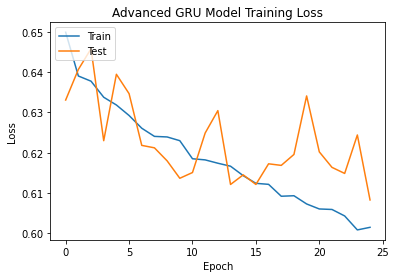

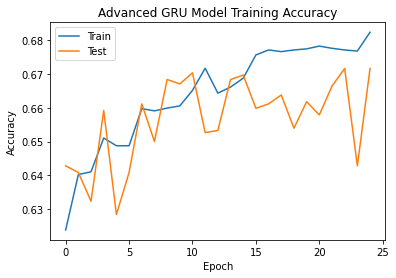

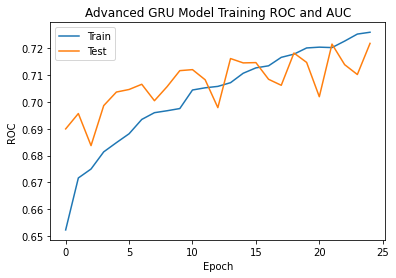

In [24]:
# Advanced GRU Model Plots

plt.plot(adv_gru_model_training.history['loss'])
plt.plot(adv_gru_model_training.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Advanced GRU Model Training Loss')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

plt.plot(adv_gru_model_training.history['accuracy'])
plt.plot(adv_gru_model_training.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Advanced GRU Model Training Accuracy')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

plt.plot(adv_gru_model_training.history['auc_2'])
plt.plot(adv_gru_model_training.history['val_auc_2'])
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.title('Advanced GRU Model Training ROC and AUC')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

# Results and Analysis

In [25]:
m1 = [lstm_model_training.history['loss'][24],lstm_model_training.history['val_loss'][24],lstm_model_training.history['accuracy'][24],lstm_model_training.history['val_accuracy'][24],lstm_model_training.history['auc'][24],lstm_model_training.history['val_auc'][24]]
m1 = [round(x,2) for x in m1]
m2 = [gru_model_training.history['loss'][24],gru_model_training.history['val_loss'][24],gru_model_training.history['accuracy'][24],gru_model_training.history['val_accuracy'][24],gru_model_training.history['auc_1'][24],gru_model_training.history['val_auc_1'][24]]
m2 = [round(x,2) for x in m2]
m3 = [adv_gru_model_training.history['loss'][24],adv_gru_model_training.history['val_loss'][24],adv_gru_model_training.history['accuracy'][24],adv_gru_model_training.history['val_accuracy'][24],adv_gru_model_training.history['auc_2'][24],adv_gru_model_training.history['val_auc_2'][24]]
m3 = [round(x,2) for x in m3]
col_names = ['Train Loss','Test Loss','Train Accuracy','Test Accuracy','Train AUC','Test AUC']
row_names = ['LSTM','GRU','Adv GRU']
res = pd.DataFrame([m1,m2,m3],row_names,col_names)
res

,Train Loss,Test Loss,Train Accuracy,Test Accuracy,Train AUC,Test AUC
LSTM,0.61,0.61,0.67,0.67,0.72,0.71
GRU,0.58,0.61,0.70,0.67,0.75,0.72
Adv GRU,0.60,0.61,0.68,0.67,0.73,0.72


The table above shows the three metrics 'Loss', 'Accuracy', and 'AUC' for each of the three models on the training and testing data after 25 iterations.

The metrics on the testing set were about the same for all three models. The metrics on the training set were slightly better for the simple GRU model. This suggests that the GRU model is slightly better than the LSTM model, but it is very close. Looking at the plots, the metrics for the testing data appear to have converged for the LSTM and simple GRU models after 25 iterations. However with the advanced GRU model, the Loss and AUC metrics appear to still be improving. We'll use this one for the submission in this competition.

In [26]:
# Testing Prediction

test['clean_text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_seq = tokenizer.texts_to_sequences(test['clean_text'])
test_pad = pad_sequences(test_seq, maxlen = 100)
test_pad = np.reshape(test_pad, (test_pad.shape[0], test_pad.shape[1], 1))

pred = adv_gru_model.predict(test_pad, verbose=1)

102/102 [==============================] - 17s 153ms/step


In [29]:
sub_df = pd.DataFrame()
sub_df['id'] = test['id']
sub_df['target'] = list(map(lambda x: 0 if x < 0.5 else 1, pred))
sub_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [30]:
sub_df['target'].value_counts()

0    2123
1    1140
Name: target, dtype: int64

In [31]:
sub_df.to_csv('submission.csv', index=False)

# Conclusion

The advanced GRU model yielded the best results. This model had four GRU layers. Each GRU layer was of size 50 and used 'tanh' activation. Each layer also included Dropout with a rate of 0.1. The output layer used sigmoid activation. This model resulted in a Loss of 0.61, Accuracy of 0.67, and AUC of 0.72 on the test data after 25 iterations. The metric plots for this model did not fully converged, so in the future with more time we would increase the number of iterations to hopefully get better results. Also in the future we could try a couple more things altering our GRU model slightly to see if we could improve it.

Our results back up the fact that GRU models are more simple and typically perform slightly better than LSTM models.

# References

Data preprocessing:
https://www.kaggle.com/code/tarundalal/beginners-guide-for-text-classification-using-lstm

Model building:
https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook